In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt

### Visualizing the first image in `/train/images` folder

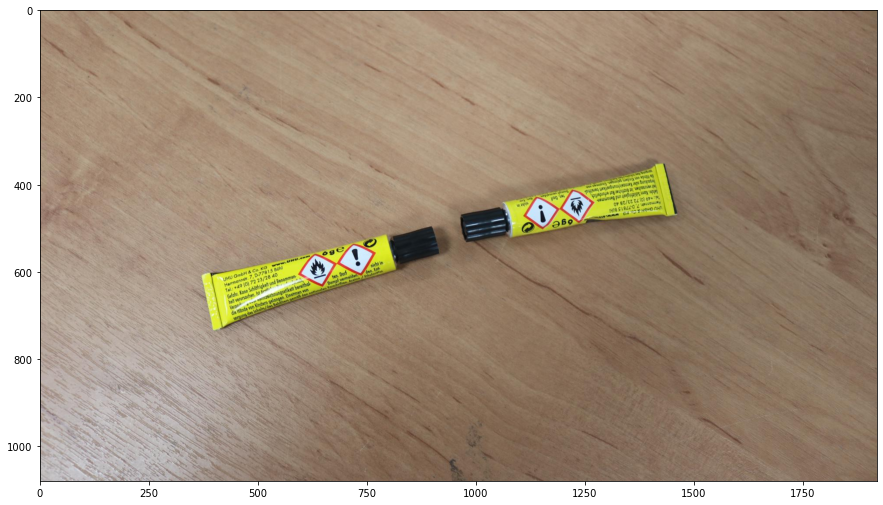

In [6]:
file_image_example = '/path/to/dataset/train/images/IMG_4801_JPG_jpg.rf.004c63fe3ea1692644120c6040d32108.jpg'

img = cv2.imread(file_image_example)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img)

### Looking at the data in the first txt-file in `/train/labels` folder

In [8]:
file_labels_example = '/path/to/dataset/train/labels/IMG_4801_JPG_jpg.rf.004c63fe3ea1692644120c6040d32108.txt'

with open(file_labels_example) as f:
    lines_txt = f.readlines()
    lines = []
    for line in lines_txt:
        lines.append([int(line.split()[0])] + [round(float(el), 7) for el in line.split()[1:]])

for idx, line in enumerate(lines):
    print("Rectangle {}:".format(idx+1), line)

Rectangle 1: [2, 0.7460938, 0.374537, 0.0015625, 0.0027778]
Rectangle 2: [0, 0.6315104, 0.4097222, 0.2598958, 0.1712963]
Rectangle 3: [1, 0.5307292, 0.4509259, 0.0020833, 0.0037037]
Rectangle 4: [1, 0.4484375, 0.4944444, 0.0020833, 0.0037037]
Rectangle 5: [0, 0.3372396, 0.5666667, 0.2859375, 0.2268519]
Rectangle 6: [2, 0.2044271, 0.6171296, 0.0026042, 0.0046296]


### Function which converts annotations from Roboflow format to the format required by KeypointRCNN model

In [9]:
keypoint_names = ['Head', 'Tail']

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]
    
    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes
        if line[0] == 0:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints. In our case 1 is for head, 2 is for tail.
        if line[0] != 0:
            kp_id, x_c, y_c = line[0] - 1, round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are sorting keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                
    return bboxes, keypoints_sorted

### Demo of how converting function works

In [10]:
bboxes, keypoints_sorted = converter(file_labels_example, file_image_example, keypoint_names)

print("Bboxes:", bboxes)
print("Keypoints:", keypoints_sorted)

Bboxes: [[962, 350, 1462, 534], [374, 490, 922, 734]]
Keypoints: [[[1019, 487, 1], [1432, 405, 1]], [[861, 534, 1], [393, 667, 1]]]


### Visualizing bounding boxes and keypoints on the image

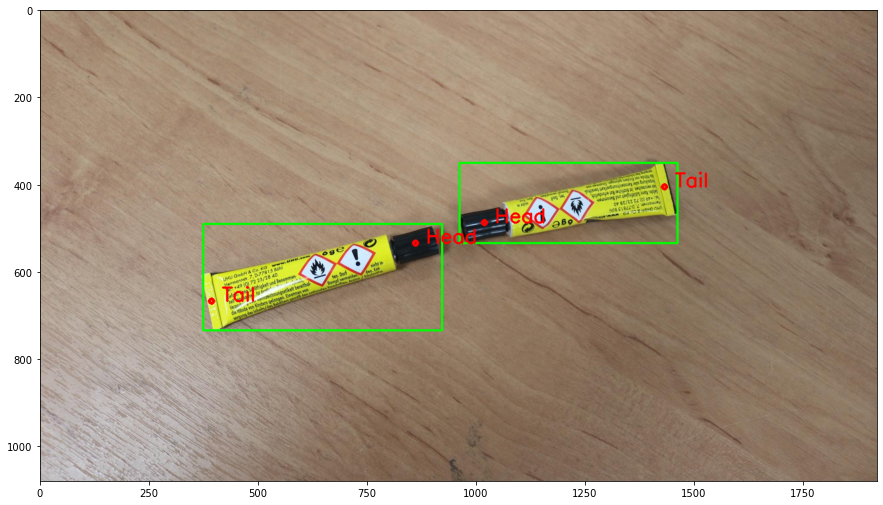

In [11]:
for bbox_idx, bbox in enumerate(bboxes):
    top_left_corner, bottom_right_corner = tuple([bbox[0], bbox[1]]), tuple([bbox[2], bbox[3]])
    img = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), 3)
    
    for kp_idx, kp in enumerate(keypoints_sorted[bbox_idx]):
        center = tuple([kp[0], kp[1]])
        img = cv2.circle(img, center, 5, (255,0,0), 5)
        img = cv2.putText(img, " " + keypoint_names[kp_idx], center, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
        
plt.figure(figsize=(15,15))
plt.imshow(img)

### Function which saves annotations into json-file

In [12]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

### Create `/train/annotations` folder
### Convert annotations and save them in a new format

In [13]:
IMAGES = '/path/to/dataset/train/images'
LABELS = '/path/to/dataset/train/labels'
ANNOTATIONS = '/path/to/dataset/train/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))